### Ex 1

In [1]:
import networkx as nx
import numpy as np
from scipy.linalg import eigh
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import random

In [2]:
G = nx.Graph()

with open("CA-AstroPh.txt", 'r') as file:
    for line in file:
        if line.startswith("#"):
            continue
        
        node1, node2 = line.split()
        node1 = int(node1)
        node2 = int(node2)
        
        if G.has_edge(node1, node2):
            G[node1][node2]['weight'] += 1
        else:
            G.add_edge(node1, node2, weight=1)

G = nx.subgraph(G, list(G.nodes)[:1500])


In [3]:
features = {}

for node in G.nodes:
        # number of neighbors
        neighbors = list(G.neighbors(node))
        Ni = len(neighbors)

        # number of edges in egonet i
        egonet = G.subgraph(neighbors)  
        Ei = len(egonet.edges)  

        # total weight of egonet i
        Wi = sum(G[n1][n2]['weight'] for n1, n2 in egonet.edges)

        # principal eigenvalue of the weighted adjacency matrix of egonet
        if len(egonet) > 0:
            A = nx.to_numpy_array(egonet)
            eigenvalues, _ = eigh(A)
            L = max(eigenvalues)
        else:
            L = 0
            
        features[node] = {"Ni": Ni, "Ei": Ei, "Wi": Wi, "L": L}

nx.set_node_attributes(G, features)

In [4]:
nodes = list(G.nodes())
Ei = np.array([G.nodes[n]['Ei'] for n in nodes])
Ni = np.array([G.nodes[n]['Ni'] for n in nodes])

Ei = np.log(Ei + 1)
Ni = np.log(Ni + 1)

model = LinearRegression()
model.fit(Ni.reshape(-1, 1), Ei)

C = np.exp(model.intercept_) 
theta = model.coef_[0]

pred_Ei = C * (Ni ** theta)

scores = {}
for i, node in enumerate(nodes):
    if pred_Ei[i] == 0 or Ei[i] == 0:
        score = 0
    else:
        score = (max(Ei[i], pred_Ei[i]) / min(Ei[i], pred_Ei[i])) * np.log(abs(Ei[i] - pred_Ei[i]) + 1)
    
    scores[node] = score  

sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]

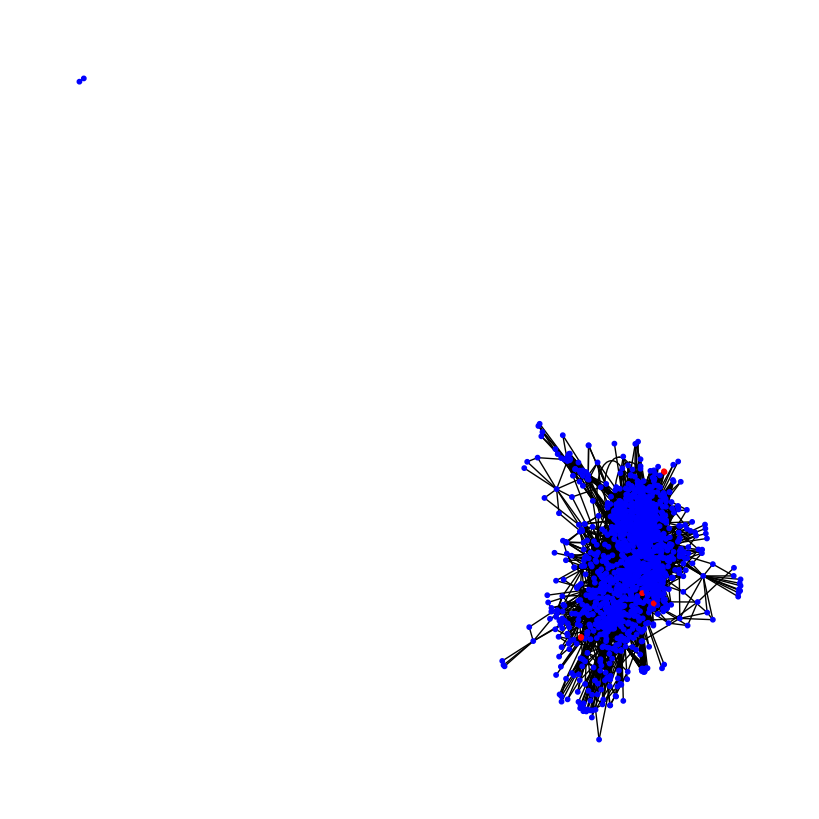

In [5]:
colors = ['red' if node in dict(sorted_scores).keys() else 'blue' for node in G.nodes()]
plt.figure(figsize=(8, 8))
position = nx.spring_layout(G, seed=42)
nx.draw(G, position, node_color=colors, node_size=10)
plt.show()

In [6]:
# LOF
features = np.column_stack((Ni, Ei))
lof = LocalOutlierFactor(n_neighbors=50)
lof.fit(features) 
lof_scores = -lof.negative_outlier_factor_

In [7]:
scores = np.array([scores[node] for node in nodes])
new_scores = scores + lof_scores

new_scores_dict = {nodes[i]: new_scores[i] for i in range(len(nodes))}
sorted_new_scores = sorted(new_scores_dict.items(), key=lambda x: x[1], reverse=True)
top_nodes = [node for node, _ in sorted_new_scores[:10]]

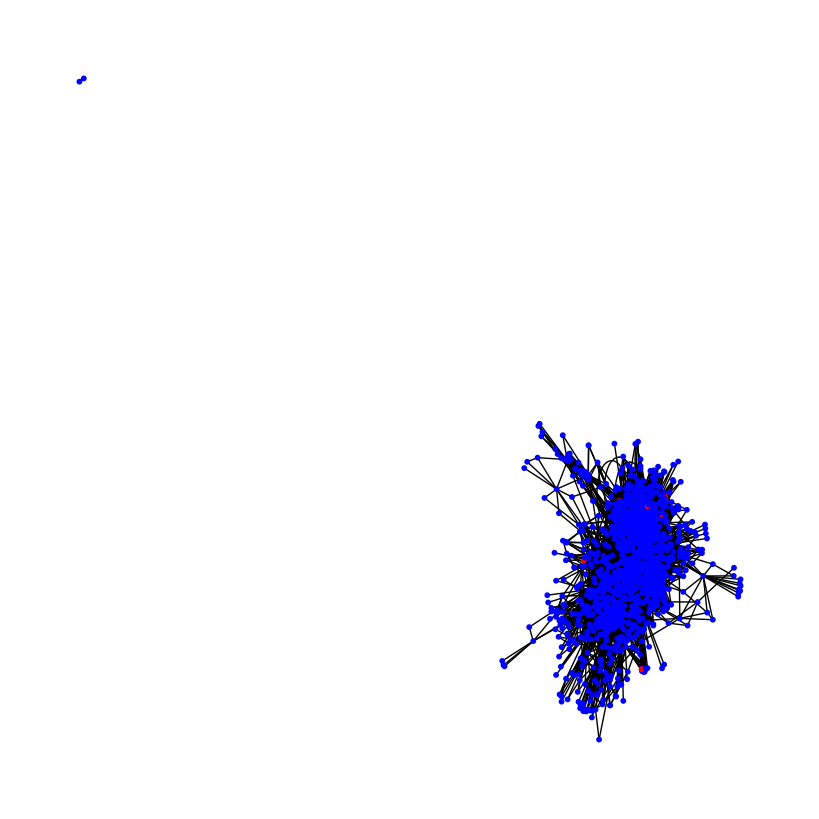

In [8]:
colors = ['red' if node in top_nodes else 'blue' for node in G.nodes()]
plt.figure(figsize=(8,8))
nx.draw(G, position, node_color=colors, node_size=10)
plt.show()

### Ex 2

1

In [9]:
G1 = nx.random_regular_graph(3, 100)
G2 = nx.connected_caveman_graph(10, 20)
G = nx.union(G1, G2, rename=("New_G1", "New_G2"))

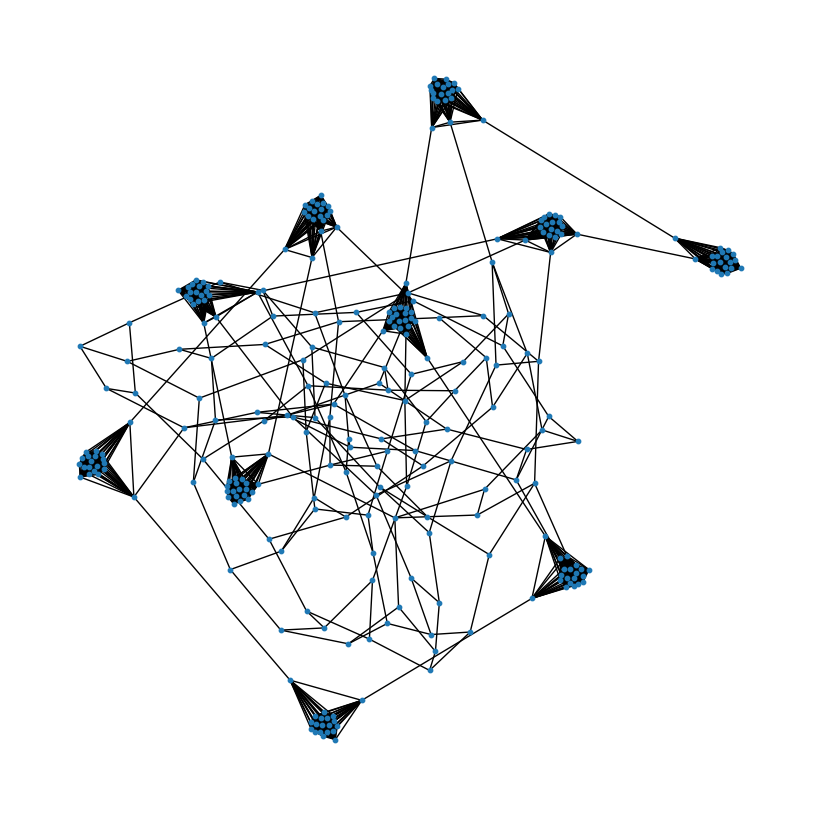

In [10]:
nodes_G1 = [n for n in G if n.startswith('New_G1')]
nodes_G2 = [n for n in G if n.startswith('New_G2')]

for _ in range(15):
        node_G1 = random.choice(nodes_G1)
        node_G2 = random.choice(nodes_G2)
        G.add_edge(node_G1, node_G2)

plt.figure(figsize=(8, 8))
position = nx.spring_layout(G, seed=42) 
nx.draw(G, position, node_size=10)
plt.show()

In [11]:
features = {}

for node in G.nodes:
        # number of neighbors
        neighbors = list(G.neighbors(node))
        Ni = len(neighbors)

        # number of edges in egonet i
        egonet = G.subgraph(neighbors)  
        Ei = len(egonet.edges)  

            
        features[node] = {"Ni": Ni, "Ei": Ei}

nx.set_node_attributes(G, features)

In [12]:
nodes = list(G.nodes())
Ei = np.array([G.nodes[n]['Ei'] for n in nodes])
Ni = np.array([G.nodes[n]['Ni'] for n in nodes])

Ei = np.log(Ei + 1)
Ni = np.log(Ni + 1)

model = LinearRegression()
model.fit(Ni.reshape(-1, 1), Ei)

C = np.exp(model.intercept_) 
theta = model.coef_[0]

pred_Ei = C * (Ni ** theta)

scores = {}
for i, node in enumerate(nodes):
    if pred_Ei[i] == 0 or Ei[i] == 0:
        score = 0
    else:
        score = (max(Ei[i], pred_Ei[i]) / min(Ei[i], pred_Ei[i])) * np.log(abs(Ei[i] - pred_Ei[i]) + 1)
    
    scores[node] = score  

sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]

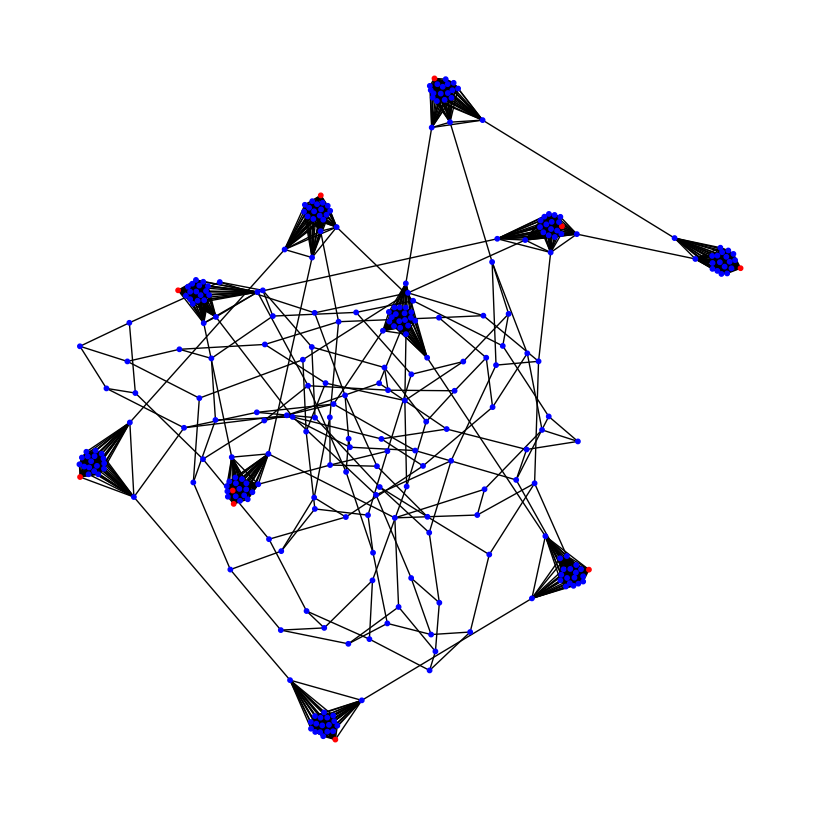

In [13]:
colors = ['red' if node in dict(sorted_scores).keys() else 'blue' for node in G.nodes()]
plt.figure(figsize=(8, 8))
position = nx.spring_layout(G, seed=42)
nx.draw(G, position, node_color=colors, node_size=10)
plt.show()

2

In [14]:
G1 = nx.random_regular_graph(3, 100)
G2 = nx.random_regular_graph(5, 100)
G = nx.union(G1, G2, rename=("New_G1", "New_G2"))

nodes_G1 = [n for n in G if n.startswith('New_G1')]
nodes_G2 = [n for n in G if n.startswith('New_G2')]

for _ in range(15):
        node_G1 = random.choice(nodes_G1)
        node_G2 = random.choice(nodes_G2)
        G.add_edge(node_G1, node_G2)

In [15]:
for edge in G.edges():
    G.add_edge(edge[0], edge[1], weight=1)

random_nodes = random.sample(list(G.nodes()), 2)

for node in random_nodes:
    neighbors = list(G.neighbors(node))
    for neighbor in neighbors:
        G[node][neighbor]['weight'] += 10

In [16]:
features = {}

for node in G.nodes:
        # number of edges in egonet i
        egonet = G.subgraph(neighbors)  
        Ei = len(egonet.edges)  

        # total weight of egonet i
        Wi = sum(G[n1][n2]['weight'] for n1, n2 in egonet.edges)
            
        features[node] = {"Ei": Ei, "Wi": Wi}

nx.set_node_attributes(G, features)

In [17]:
nodes = list(G.nodes())
Ei = np.array([G.nodes[n]['Ei'] for n in nodes])
Wi = np.array([G.nodes[n]['Wi'] for n in nodes])

Ei = np.log(Ei + 1)
Wi = np.log(Wi + 1)

model = LinearRegression()
model.fit(Wi.reshape(-1, 1), Ei)

C = np.exp(model.intercept_) 
theta = model.coef_[0]

pred_Ei = C * (Wi ** theta)

scores = {}
for i, node in enumerate(nodes):
    if pred_Ei[i] == 0 or Ei[i] == 0:
        score = 0
    else:
        score = (max(Ei[i], pred_Ei[i]) / min(Ei[i], pred_Ei[i])) * np.log(abs(Ei[i] - pred_Ei[i]) + 1)
    
    scores[node] = score  

sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:4]

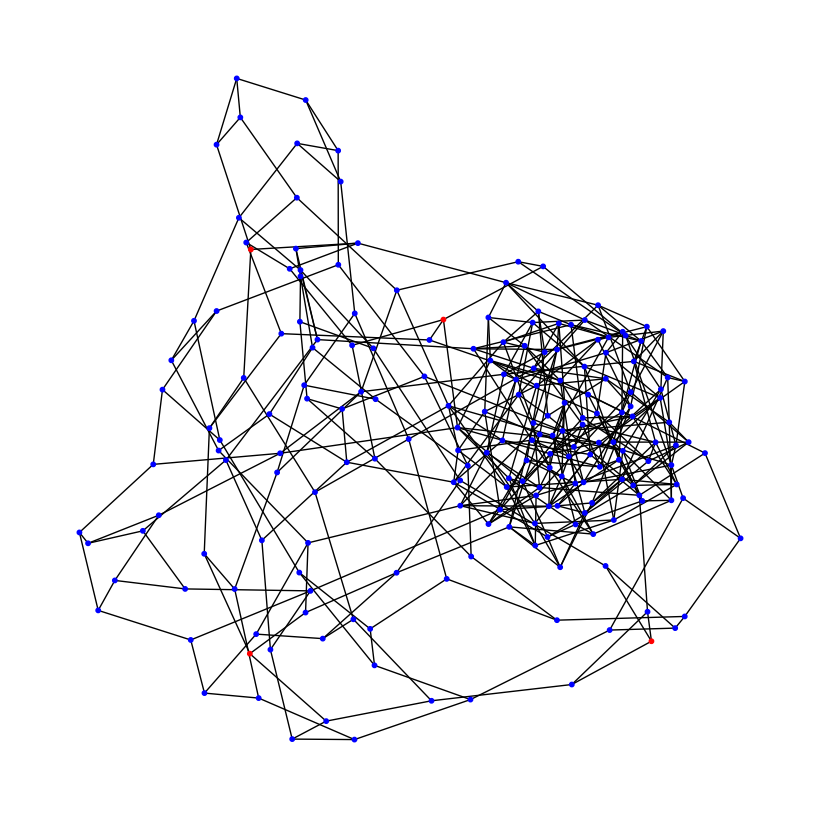

In [18]:
colors = ['red' if node in dict(sorted_scores).keys() else 'blue' for node in G.nodes()]
plt.figure(figsize=(8, 8))
position = nx.spring_layout(G, seed=42)
nx.draw(G, position, node_color=colors, node_size=10)
plt.show()